- Title: Under the Hood of K-Nearest Neighbors (KNN) and Popular Model Validation Techniques
- Date: 2020-08-31 11:00
- Category: notebook
- Authors: Amit Gattadahalli
- This article contains in-depth algorithm overviews of the K-Nearest Neighbors algorithm (Classification and Regression) as well as the following Model Validation techniques: Traditional Train/Test Split and Repeated K-Fold Cross Validation. The algorithm overviews include detailed descriptions of the methodologies and mathematics that occur internally with accompanying concrete examples. Also included are custom, fully functional/flexible frameworks of the above algorithms built from scratch using primarily NumPy. Finally, there is a fully integrated Case Study which deploys several of the custom frameworks (KNN-Classification, Repeated K-Fold Cross Validation) through a full Machine Learning workflow alongside the Iris Flowers dataset to find the optimal KNN model.
- Tags: Machine Learning, K Nearest Neighbors, Cross Validation, Iris, Python
- GitHub: https://github.com/Amitg4/KNN_ModelValidation

**Please use the imports below to run any included code within your own notebook or coding environment.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from statistics import mean,stdev
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline

## KNN Algorithm Overview
K-Nearest Neighbors is a popular pattern recognition algorithm used in Supervised Machine Learning to handle both classification and regression-based tasks. At a high level, this algorithm operates according to an intuitive methodology:

*New points target values are predicted according to the target values of the K most similar points stored in the model’s training data.*

Traditionally, 'similar' is interpreted as some form of a distance calculation. Therefore, another way to interpret the KNN prediction methodology is that **predictions are based off the K closest points within the training data, hence the name K-Nearest Neighbors**. With the concept of distance introduced, a good initial question to answer is how distance will be computed. While there are several different mathematical metrics that are viewed as a form of computing distance, this study will highlight the 3 following distance metrics: Euclidean, Manhattan, and Chebyshev.

### KNN Algorithm Overview - Distance Metrics

**Euclidean distance**, based in the Pythagorean Theorem, finds the straight line distance between two points in space. In other words, this is equivalent to finding the shortest distance between two points by drawing a single line between Point A and Point B. **Manhattan distance**, based in taxicab geometry, is the sum of all N distances between Point A and Point B in N dimensional feature space. For example, in 2D space the Manhattan distance between Point A and Point B would be the sum of the vertical and horizontal distance. **Chebyshev distance** is the maximum distance between Point A and Point B in N dimensional feature space. For example, in 2D space the Chebyshev distance between Point A and Point B would be max(horizontal distance, vertical distance), in other words whichever distance is greater between the two distances. 

Consider Point A = (A_1, A_2, ... , A_N) and Point B = (B_1, B_2, ... , B_N) both exist in N dimensional feature space. The distance between these two points can be described by the following formulas:

Euclidean Distance = $\sqrt{\sum_{i=1}^n (A_i - B_i)^2}$  

Manhattan Distance = $\sum_{i=1}^n \lvert A_i - B_i \rvert$  

Chebyshev Distance = $max(\lvert A_1 - B_1 \rvert, \lvert A_2 - B_2 \rvert, ... , \lvert A_N - B_N \rvert)$  

As with most mathematical concepts, distance metrics are often easier to understand with a concrete example to visualize. Consider Point A = (0,0) and Point B = (3,4) in 2D feature space.

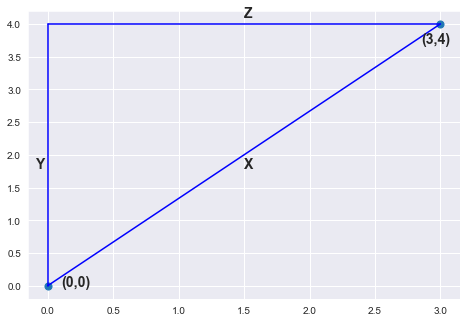

In [2]:
sns.set_style('darkgrid')
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.scatter(x=[0,3],y=[0,4],s = 50)
axes.plot([0,3],[0,4],c='blue')
axes.annotate('X',[1.5,1.8],fontsize = 14,fontweight = 'bold')
axes.plot([0,0],[0,4],c='blue')
axes.annotate('Y',[-0.1,1.8],fontsize = 14,fontweight = 'bold')
axes.plot([0,3],[4,4],c='blue')
axes.annotate('Z',[1.5,4.1],fontsize = 14,fontweight = 'bold')
axes.annotate('(0,0)',[0.1,0.0],fontsize = 14,fontweight = 'bold')
axes.annotate('(3,4)',[2.85,3.7],fontsize = 14,fontweight = 'bold')
axes.grid(lw=1)
plt.show()

Segment X is the straight line distance between Point A and Point B. Segment Y is the vertical distance between Point A and Point B. Segment Z is the horizontal distance between Point A and Point B. Using the distance metrics as detailed above, let us compute the distance between Point A and Point B:

Euclidean distance = $\sqrt{(3-0)^2 + (4-0)^2} = \sqrt{9 + 16} = \sqrt{25}=5$ or the length of Segment X  
Manhattan distance = $\lvert 3 - 0 \rvert + \lvert 4 - 0 \rvert = 3 + 4 = 7$ or length of Segment Y + length of Segment Z    
Chebyshev distance = $max(\lvert 3 - 0 \rvert,\lvert 4 - 0 \rvert) = max(3,4) = 4$ or max(length of Segment Y, length of Segment Z)

**Important Note: Because KNN utilizes distance measurements as a key component, feature scaling is especially important to ensure one feature does not mask the input of other features**

### KNN Algorithm Overview - Classification
Classification is a supervised machine learning concept which categorizes data into classes. 

Suppose a dataset is split into training data, data which allows the model to learn, and test data, data that allows us to validate model performance. The KNN Algorithm supports classification tasks through the following general algorithm structure:

**Step 1:** Select a K Value, Distance Metric, and Weighting Schema (covered later!) for the model  
**Step 2:** Train the model with training data  
**Step 3:** Compute distance using the selected distance metric between $i^{th}$ test/new observation and every training observation, while storing distances and training labels in a data structure  
**Step 4:** Sort the data structure in ascending order by distance  
**Step 5:** Use the K closet points and the selected weighting schema to vote on the class of the test/new observation, where the class with the majority vote is selected as the prediction  
**Step 6:** Repeat Steps 3-5 until a prediction has been made for every test observation  
**Step 7:** Return predictions  
**Step 8:** If predictions are for test observations, then compare test labels to predictions in order to assess model accuracy 

#### Classification Weighting Schema
Mentioned above in the classification algorithm steps was selecting and utilizing a 'Weighting Schema'. This sub-section will briefly walk through what this means alongside a concrete example.  

A weighting schema dictates how much influence each of the K closest points will have towards making a final prediction. While there are many weighting schemas out there used alongside KNN, this study will focus on two:

**Schema 1 -- Traditional or 'standard'**: This voting schema assumes all points have equal influence over the final prediction. In a classification setting this means each of the K closest points will cast 1 vote  
**Schema 2 -- Custom Weighted or 'weighted'**: This voting schema assumes that the closer a point is, the more influence it has over the final prediction. In a classification setting this means the closest point will cast K votes, the $2^{nd}$ closest will cast K - 1 votes, and so on and so forth until the $K^{th}$ closest point casts 1 vote. Formulaically, this is shown by $# of votes = K+1-position$, where position is how close it is to the new point.

See below for a concrete example:

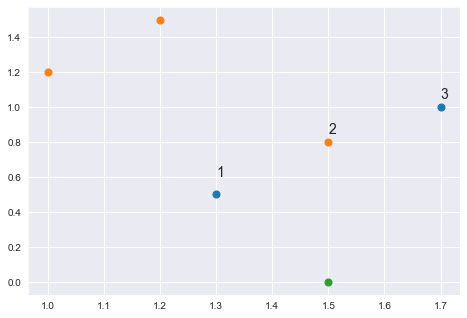

In [3]:
sns.set_style('darkgrid')
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.scatter(x=[1.3,1.7],y=[0.5,1],s = 50)
axes.scatter(x=[1.5,1,1.2],y=[0.8,1.2,1.5],s = 50)
axes.scatter(x=[1.5],y=[0],s = 50)
axes.annotate('1',[1.3,0.6],fontsize = 14)
axes.annotate('2',[1.5,0.85],fontsize = 14)
axes.annotate('3',[1.7,1.05],fontsize = 14)
axes.grid(lw=1)
plt.show()

The example above shows 5 total points in the training data, where every point is either class blue or class orange. The green data point is the new point which we are trying to classify based off the training data. Assuming a Euclidean distance metric and a 3-Nearest Neighbors framework, Points 1,2 and 3 are the closest points to the new observation in that order.

The 'standard' weighting schema would vote in the following format:
-    Point 1 would have 1 vote towards class blue
-    Point 2 would have 1 vote towards class orange
-    Point 3 would have 1 vote towards class orange  

**With two votes for class blue and one vote for class orange, the new observation would be classified as a class blue under the 'standard' schema.**

The 'weighted' weighting schema would vote in the following format:
-    Point 1 would have 3 vote towards class blue
-    Point 2 would have 2 vote towards class orange
-    Point 3 would have 1 vote towards class orange  

**With four votes for class blue and two votes towards class orange, the new observation would be classified as a class blue under the 'weighted' schema.**

#### The Algorithm  
Below is our construction of the KNN Algorithm for Classification built entirely from scratch using NumPy. The framework is fully flexible for any sized data set (any any number of classes!), and supports the following methods:
-    First the model must be instantiated. Generalized syntax will be **model = KNNClass(k,weighting = 'standard',distance_metric = 'euclidean')**. The user must pass in a positive integer for k, and may optionally pass in values for weighting ('standard','weighted') and distance_metric ('euclidean','manhattan','chebyshev')
-    After the model has been instantiated, it must be fit with training data. Generalized syntax will be **model.fit(xtrain,ytrain)**
-    After the model has been instantiated and fit with training data, the model can begin predicting values. Generalized syntax will be **predictions = model.predict(xtest)** where predictions for the test data will be returned in a NumPy array
-    After the model has been instantiated and fit with training data, the score method can be used to return an accuracy score. Generalized syntax will be **model.score(X,Y)**. The method will then make predictions for X, compare them to Y, and return the proportion of correct predictions.

For more information on the inner workings of the custom framework below, please refer to the comments and general code within the code block.

In [4]:
#KNN CLASSIFICATION FRAMEWORK
class KNNClass:
    
    def __init__(self,k,weighting = 'standard',distance_metric = 'euclidean'):
        #WHEN INSTANTIATING A MODEL, SPECIFY A MANDATORY K - VALUE SIGNIFYING THE NUMBER OF NEAREST NEIGHBORS THE MODEL
        #WILL UTILIZE TO MAKE EACH PREDICTIONS. OPTIONALLY, THE USER MAY ALSO SPECIFY A WEIGHTING SCHEMA (STANDARD/WEIGHTING)
        #AND DISTANCE_METRIC (EUCLIDEAN/MANHATTAN/CHEBYSHEV)
        self.k = k
        self.weighting = weighting
        self.distance_metric = distance_metric
    
    def fit(self,Xtrain,Ytrain):
        #BEFORE MAKING PREDICTIONS, THE MODEL MUST BE FIT WITH THE TRAINING DATA. THIS MEANS THE FEATURE DATA AS XTRAIN AND 
        #LABELS AS YTRAIN. 
        self.xtrainmatrix = np.matrix(Xtrain)
        self.ytrainmatrix = np.matrix(Ytrain)
        if self.xtrainmatrix.shape[0] == 1:
            self.xtrainmatrix = self.xtrainmatrix.transpose()
        if self.ytrainmatrix.shape[0] == 1:
            self.ytrainmatrix = self.ytrainmatrix.transpose()
        
        #IN ADDITION TO STORING THE TRAINING DATA, THE FIT METHOD WILL ALSO STORE A LIST OF THE LABELS AND THE TOTAL NUMBER OF
        #FEATURES

        self.labellist = list(set(np.array(self.ytrainmatrix).squeeze()))
        self.numfeatures = self.xtrainmatrix.shape[1]
    
    def predict(self,Xtest):
        #AFTER THE MODEL HAS BEEN INSTANTIATED AND FIT WITH TRAINING DATA, THE PREDICT METHOD CAN BE USED TO RETURN A NUMPY 
        #ARRAY OF PREDICTED VALUES. TO PROPERLY EXECUTE THIS METHOD, PASS IN THE TEST FEATURE DATA (UNLABELED) FOR XTEST.
        self.xtestmatrix = np.matrix(Xtest)
        if self.xtestmatrix.shape[0] == 1:
            self.xtestmatrix = self.xtestmatrix.transpose()
        #BEGIN COMPARING TEST OBS TO TRAINING OBS
        preds = []
        for testobs in self.xtestmatrix:
            distance = []
            for trainobs in self.xtrainmatrix:
                #CALCULATE DISTANCE BETWEEN TEST OBS AND TRAINING OBS
                #DISTANCE_METRIC = 'EUCLIDEAN' CALCULATES EUCLIDEAN DISTANCE: SQRT(SUM((X-Y)**2))
                #DISTANCE_METRIC = 'MANHATTAN' CALCULATES MANHATTAN DISTANCE: SUM(ABS(X-Y))
                #DISTANCE_METRIC = 'CHEBYSHEV' CALCULATES CHEBYSHEV DISTANCE: MAX(ABS(X-Y))
                if self.distance_metric == 'euclidean':
                    sums = 0
                    for num in range(0,self.numfeatures):
                        sums = sums + (testobs[0,num]-trainobs[0,num])**2
                    distance.append(np.sqrt(sums))
                elif self.distance_metric == 'manhattan':
                    sums = 0
                    for num in range(0,self.numfeatures):
                        sums = sums + abs(testobs[0,num]-trainobs[0,num])
                    distance.append(sums)
                elif self.distance_metric == 'chebyshev':
                    sums = []
                    for num in range(0,self.numfeatures):
                        sums.append(abs(testobs[0,num]-trainobs[0,num]))
                    distance.append(max(sums))
            #CREATE A MATRIX WITH YTRAIN AND DISTANCE COLUMN, REPRESENTING THE DISTANCE BETWEEN TEST/TRAINING OBS AND THE TRAINING OUTPUT
            #SORT MATRIX BY DISTANCE
            distancecol = np.matrix(distance).transpose()
            ytrainmatrix2 = np.hstack((self.ytrainmatrix,distancecol))
            ytrainmatrix2 = np.matrix(sorted(np.array(ytrainmatrix2),key=lambda x:x[1]))
            #CREATE VOTING FRAMEWORK, TRACK NUMBER OF VOTES PER LABEL ACROSS N NEAREST TRAINING POINTS FOR TEST OBS
            #IF WEIGHTING = 'STANDARD', A STANDARD VOTING SCHEMA IS FOLLOWED WHERE EACH OF THE K NEAREST POINTS ARE GIVEN THE SAME WEIGHT
            #IF WEIGHTING = 'WEIGHTED', A WEIGHTED VOTING SCHEMA IS FOLLOWED WHERE CLOSER POINTS WILL HAVE A HEAVIER WEIGHT BY MEANS OF INCREASED NUMBER OF VOTES
            if self.weighting == 'standard':
                labelcount = []
                for labels in self.labellist:
                    count = 0
                    for num in range(0,self.k):
                        if ytrainmatrix2[num,0] == labels:
                            count = count + 1
                    labelcount.append(count)
            elif self.weighting == 'weighted':
                labelcount = []
                for labels in self.labellist:
                    count = 0
                    for num in range(0,self.k):
                        if ytrainmatrix2[num,0] == labels:
                            count = count + self.k - num
                    labelcount.append(count)
            #CREATE AN ADDED VOTING LAYER FOR SCENARIOS IN WHICH THERE IS A TIE FOR MOST VOTES
            predlabel = []
            for num in range(0,len(labelcount)):
                if labelcount[num] == max(labelcount):
                    predlabel.append(self.labellist[num])
            if len(predlabel) == 1:
                preds.append(predlabel[0])
            else:
                preds.append(predlabel[np.random.randint(0,len(predlabel))])
        #RETURN A NUMPY ARRAY OF PREDICTED VALUES
        return np.array(preds)
    
    def score(self,X,Y):
        #AFTER THE MODEL HAS BEEN INSTANTIATED AND FIT, THE SCORE METHOD MAY BY USED TO RETURN AN ACCURACY SCORE FOR THE MODEL 
        #GIVEN TEST FEATURES AND TEST LABELS. 
        
        #THIS METHOD WORKS BY PASSING IN THE TEST FEATURES (X), UPON WHICH THE PREDICT 
        #METHOD ABOVE WILL CALLED TO RETURN A NUMPY ARRAY OF PREDICTED VALUES. 
        
        preds = self.predict(X)
        Y = np.array(Y)
        totalpreds = len(preds)
        
        #THESE VALUES WILL BE COMPARED TO THE TEST LABELS(Y) AND AN ACCURACY SCORE WILL BE 
        #RETURNED AS A VALUE BETWEEN 0-1 COMPUTED BY (CORRECTED PREDS)/(TOTAL PREDS).
        
        comparelist = []
        count = 0
        for num in range(0,totalpreds):
            if preds[num] == Y[num]:
                comparelist.append(1)
            else:
                comparelist.append(0)
        return sum(comparelist)/len(comparelist)
        

### KNN Algorithm Overview - Regression
Regression is a supervised machine learning task which predicts continuous values for data.

Suppose a dataset is split into training data, data which allows the model to learn, and test data, data that allows us to validate model performance. The KNN Algorithm supports regression tasks through the following general algorithm structure:

**Step 1:** Select a K Value, Distance Metric, and Weighting Schema for the model  
**Step 2:** Train the model with training data  
**Step 3:** Compute distance using the selected distance metric between $i^{th}$ test/new observation and every training observation, while storing distances and training labels in a data structure  
**Step 4:** Sort the data structure in ascending order by distance  
**Step 5:** Use the K closet points and the selected weighting schema to predict the value of the test/new observation
**Step 6:** Repeat Steps 3-5 until a prediction has been made for every test observation  
**Step 7:** Return predictions  
**Step 8:** If predictions are for test observations, then compare test labels to predictions in order to assess model accuracy

#### Regression Weighting Schema
Similar to the classification example, a weighting schema can also be used in KNN Regression to dictate how much influence each of the K closest points will have towards making a final prediction. While there are many weighting schemas out there used alongside KNN, this study will focus on two:

**Schema 1 -- Traditional or 'standard'**: This voting schema assumes all points have equal influence over the final prediction. In a regression setting this means each of the K closeest points will be weighted equally or, in other words, the predicted value is the average of the K closest points.   
**Schema 2 -- Custom Weighted or 'weighted'**: This voting schema assumes that the closer a point is, the more influence it has over the final prediction. In a regression setting this means that each of the K closest points will be assigned a $weight = \frac{(K + 1 - position)}{\sum_{i=1}^K i}$ where position indicates how close it is to the new point. The final prediction is then the weighted average of the K closest points.

See below for a concrete example:

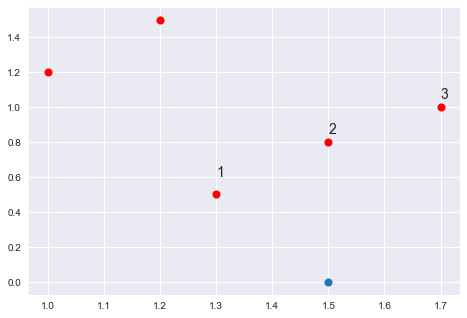

In [5]:
sns.set_style('darkgrid')
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.scatter(x=[1.3,1.7],y=[0.5,1],s = 50,color = 'red')
axes.scatter(x=[1.5,1,1.2],y=[0.8,1.2,1.5],s = 50,color = 'red')
axes.scatter(x=[1.5],y=[0],s = 50)
axes.annotate('1',[1.3,0.6],fontsize = 14)
axes.annotate('2',[1.5,0.85],fontsize = 14)
axes.annotate('3',[1.7,1.05],fontsize = 14)
axes.grid(lw=1)
plt.show()

The example above shows 5 total points in the training data, marked by the color red. The blue data point is the new point which we are trying to predict based off the training data. Assuming a Euclidean distance metric and a 3-Nearest Neighbors framework, Points 1,2 and 3 are the closest points to the new observation in that order. Suppose Points 1, 2, and 3 have values 50, 55, and 60 units respectively.

The 'standard' weighting schema would calculate in the following format:  
$Prediction = \frac {50 + 55 + 60}{3} = 55$

The 'weighted' weighting schema calculate in the following format:
-    Point 1 $weight = \frac{3}{6}$
-    Point 2 $weight = \frac{2}{6}$
-    Point 3 $weight = \frac{1}{6}$  

$Prediction = (50)*(\frac{3}{6})+(55)*(\frac{2}{6})+(60)*(\frac{1}{6}) = 53.33$

#### The Algorithm  
Below is our construction of the KNN Algorithm for Regression built entirely from scratch using NumPy. Similar to the classification framework, the regression framework is fully flexible for any sized data set, and supports the following methods:
-    First the model must be instantiated. Generalized syntax will be **model = KNNReg(k,weighting = 'standard',distance_metric = 'euclidean')**. The user must pass in a positive integer for k, and may optionally pass in values for weighting ('standard','weighted') and distance_metric ('euclidean','manhattan','chebyshev')
-    After the model has been instantiated, it must be fit with training data. Generalized syntax will be **model.fit(xtrain,ytrain)**
-    After the model has been instantiated and fit with training data, the model can begin predicting values. Generalized syntax will be **predictions = model.predict(xtest)** where predictions for the test data will be returned in a NumPy array
-    After the model has been instantiated and fit with training data, the score method can be used to return an accuracy score. Generalized syntax will be **model.score(X,Y,error_metric = 'rmse')**. The method will then make predictions for X, compare them to Y, and return an error score according to the optional error_metric ('rmse','mse','mae') pass in. The error_metric values indicate scoring based off Root Mean Square Error, Mean Square Error, and Mean Absolute Error.

For more information on the inner workings of the custom framework below, please refer to the comments and general code within the code block.

In [6]:
#KNN REGRESSION FRAMEWORK
class KNNReg:
    
    def __init__(self,k,weighting = 'standard',distance_metric = 'euclidean'):
        #WHEN INSTANTIATING A MODEL, SPECIFY A MANDATORY K - VALUE SIGNIFYING THE NUMBER OF NEAREST NEIGHBORS THE MODEL
        #WILL UTILIZE TO MAKE EACH PREDICTIONS. OPTIONALLY, THE USER MAY ALSO SPECIFY A WEIGHTING SCHEMA (STANDARD/WEIGHTING)
        #AND DISTANCE_METRIC (EUCLIDEAN/MANHATTAN/CHEBYSHEV)
        self.k = k
        self.weighting = weighting
        self.distance_metric = distance_metric
        
    def fit(self,Xtrain,Ytrain):
        #BEFORE MAKING PREDICTIONS, THE MODEL MUST BE FIT WITH THE TRAINING DATA. THIS MEANS THE FEATURE DATA AS XTRAIN AND 
        #LABELS AS YTRAIN. 
        self.xtrainmatrix = np.matrix(Xtrain)
        self.ytrainmatrix = np.matrix(Ytrain)
        if self.xtrainmatrix.shape[0] == 1:
            self.xtrainmatrix = self.xtrainmatrix.transpose()
        if self.ytrainmatrix.shape[0] == 1:
            self.ytrainmatrix = self.ytrainmatrix.transpose()
        
        #IN ADDITION TO STORING THE TRAINING DATA, THE FIT METHOD WILL ALSO STORE THE TOTAL NUMBER OF FEATURES
        self.numfeatures = self.xtrainmatrix.shape[1]
        
    def predict(self,Xtest):
        #AFTER THE MODEL HAS BEEN INSTANTIATED AND FIT WITH TRAINING DATA, THE PREDICT METHOD CAN BE USED TO RETURN A NUMPY 
        #ARRAY OF PREDICTED VALUES. TO PROPERLY EXECUTE THIS METHOD, PASS IN THE TEST FEATURE DATA (UNLABELED) FOR XTEST.
        self.xtestmatrix = np.matrix(Xtest)
        if self.xtestmatrix.shape[0] == 1:
            self.xtestmatrix = self.xtestmatrix.transpose()
        #BEGIN COMPARING TEST OBS TO TRAINING OBS
        preds = []
        for testobs in self.xtestmatrix:
            distance = []
            for trainobs in self.xtrainmatrix:
                #CALCULATE DISTANCE BETWEEN TEST OBS AND TRAINING OBS
                #DISTANCE_METRIC = 'EUCLIDEAN' CALCULATES EUCLIDEAN DISTANCE: SQRT(SUM((X-Y)**2))
                #DISTANCE_METRIC = 'MANHATTAN' CALCULATES MANHATTAN DISTANCE: SUM(ABS(X-Y))
                #DISTANCE_METRIC = 'CHEBYSHEV' CALCULATES CHEBYSHEV DISTANCE: MAX(ABS(X-Y))
                if self.distance_metric == 'euclidean':
                    sums = 0
                    for num in range(0,self.numfeatures):
                        sums = sums + (testobs[0,num]-trainobs[0,num])**2
                    distance.append(np.sqrt(sums))
                elif self.distance_metric == 'manhattan':
                    sums = 0
                    for num in range(0,self.numfeatures):
                        sums = sums + abs(testobs[0,num]-trainobs[0,num])
                    distance.append(sums)
                elif self.distance_metric == 'chebyshev':
                    sums = []
                    for num in range(0,self.numfeatures):
                        sums.append(abs(testobs[0,num]-trainobs[0,num]))
                    distance.append(max(sums))
            #CREATE A MATRIX WITH YTRAIN AND DISTANCE COLUMN, REPRESENTING THE DISTANCE BETWEEN TEST/TRAINING OBS AND THE TRAINING OUTPUT
            #SORT MATRIX BY DISTANCE
            distancecol = np.matrix(distance).transpose()
            ytrainmatrix2 = np.hstack((self.ytrainmatrix,distancecol))
            ytrainmatrix2 = np.matrix(sorted(np.array(ytrainmatrix2),key=lambda x:x[1]))
            
            #CREATE VOTING SCHEMA AMONG N CLOSEST POINTS.
            #IF INDEX = 0 THEN PREDICTED VALUE WILL BE THE AVERAGE OF THE N CLOSEST POINTS
            #IF INDEX = 1 THEN PREDICTED VALUE WILL BE A WEIGHTED AVERAGE OF N CLOSEST POINTS, WHERE CLOSER POINTS ARE WEIGHTED MORE STRONGLY TOWARDS THE PREDICTED VALUE
            if self.weighting == 'standard':
                sums = 0
                for num in range(0,self.k):
                    sums = sums + ytrainmatrix2[num,0]
                preds.append(sums/self.k)
            elif self.weighting == 'weighted':
                sums = 0
                arr = np.arange(1,self.k + 1)
                arrsum = np.sum(arr)
                for num in range(0,self.k):
                    sums = sums + ytrainmatrix2[num,0]*((self.k - num)/arrsum)
                preds.append(sums)

        #RETURN A NUMPY ARRAY OF PREDICTED VALUES
        return np.array(preds)
    
    def score(self,X,Y,error_metric = 'rmse'):
        #AFTER THE MODEL HAS BEEN INSTANTIATED AND FIT, THE SCORE METHOD MAY BY USED TO RETURN AN ACCURACY SCORE FOR THE MODEL 
        #GIVEN TEST FEATURES AND TEST LABELS. 
        
        #THIS METHOD WORKS BY PASSING IN THE TEST FEATURES (X), UPON WHICH THE PREDICT 
        #METHOD ABOVE WILL CALLED TO RETURN A NUMPY ARRAY OF PREDICTED VALUES. 
        
        preds = self.predict(X)
        Y = np.array(Y)
        totalpreds = len(preds)
        
        #THESE VALUES WILL BE COMPARED TO THE TEST LABELS(Y) AND AN ACCURACY SCORE WILL BE 
        #RETURNED. THIS VALUE WILL FOLLOW EITHER A ROOT MEAN SQUARE ERROR(RMSE), MEAN SQUARE ERROR(MSE), OR
        #MEAN ABSOLUTE ERROR(MAE) METHODOLOGY DEPENDING ON THE VALUE PASSED IN FOR ERROR_METRIC.
        
        #RMSE = SQRT(SUM((PREDICTED - ACTUAL)**2)/(TOTAL NUMBER OF PREDICTIONS))
        #MSE = SUM((PREDICTED - ACTUAL)**2)/(TOTAL NUMBER OF PREDICTIONS).
        #MAE = SUM(ABS(PREDICTED-ACTUAL))/(TOTAL NUMBER OF PREDICTIONS)
        
        if error_metric == 'rmse':
            error = 0
            for num in range(0,totalpreds):
                error = error + (preds[num] - Y[num])**2
            return np.sqrt(error/totalpreds)
            
        elif error_metric == 'mse':
            error = 0 
            for num in range(0,totalpreds):
                error = error + (preds[num] - Y[num])**2
            return error/totalpreds
            
        elif error_metric == 'mae':
            error = 0
            for num in range(0,totalpreds):
                error = error + abs(preds[num] - Y[num])
            return error/totalpreds
        


## Popular Model Validation Techniques
This section will explore 2 popular model validation techniques: **Traditional Train/Test Split**, and **Repeated K-Fold Cross Validation**. 

### Traditional Train/Test Split
The model validation process essentially evaluates the model's ability to accurately predict new data. This is generally done by first splitting labeled data into a training set and testing set. There is no accepted rule of thumb for what ratio of the data to include in training vs test sets. Some recommendations say 70/30, some say 80/20, but in reality the user can fully customize their ratio. The model is then intuitively trained on the training set before being tested on the test set. Testing in this circumstance refers to the model predicting values for the test set, comparing them to the real values for the test set, and using an error metric to evaluate the model's predictions.

Traditional Train/Test Split follows this exact methodology through for one iteration. Below is our construction of the Traditional Train/Test Split built entirely from scratch using primarily NumPy (there is some pandas for data export purposes as needed). The function is flexible for any sized data set and generally the syntax will be as follows:
-    **xtrain, xtest, ytrain, ytest = traintestsplit(X, Y, test_size)**

The user will pass in all their feature data (X), all their labels (Y), and a test_size decimal/fraction between 0 and 1. This value will dictate the size of the test set. For example, a test_size = 0.3 indicates a 70/30 split (70% of the data is training data, while 30% of the data is test data). The function will then return four data structures:
-     **xtrain**, feature data for model training, contains 1 - test_size proportion of the data
-     **xtest**, feature data for model testing, contains test_size proportion of the data
-     **ytrain**, labels for xtrain
-     **ytest**, labels for xtest

These structures can be passed directly into the KNN Frameworks mentioned above. For more information on the inner workings of the custom function below, please refer to the comments and general code within the code block.

In [7]:
#TRAIN TEST SPLIT FUNCTION
def traintestsplit(X,Y,test_size):
    """Pass into features (X), labels (Y), and test_size (decimal between 0 and 1). The function will return 4 objects: xtrain,xtest,ytrain,ytest. xtest (features) and ytest (labels) should be used for model testing purposes and contains test_size proportion of the total amount of data passed in. xtrain and ytrain contain the remaining data and are used to initially train the model"""
    
    #CONVERT TO X AND Y TO MATRICES
    Xnew = np.matrix(X)
    Ynew = np.matrix(Y)
    if Xnew.shape[0] == 1:
        Xnew = Xnew.transpose()
    if Ynew.shape[0] == 1:
        Ynew = Ynew.transpose()
        
    #IDENTIFY UNIQUE INDEXES FOR TRAINING DATA AND TEST DATA, AS WELL AS THE SIZE OF THE TEST SIZE
    idlist = [] #TEST SET INDICES
    idlist2 = [] #TRAINING SET INDICES
    
    #IDENTIFY TEST INDICES THROUGH THE FOLLOWING PROCESS:
    #STEP 1: CALCULATE SIZE OF TEST SET
    testsize = np.round(test_size*len(X))
    
    #STEP 2: CREATE A LIST OF SIZE TESTSIZE CONTAINING UNIQUE INTEGERS. INTEGERS CANNOT BE LESS THAN 0 OR GREATER THAN lEN(X)
    for num in range(0,int(testsize)):
        #STEP 2A: FOR THE FIRST ITERATION, APPEND A RANDOM INTEGER BETWEEN 0 AND LEN(X) TO IDLIST
        if num == 0:
            idlist.append(np.random.randint(0,len(X)))
        else:
        #STEP 2B: FOR ALL OTHER ITERATIONS, GENERATE A RANDOM INTEGER BETWEEN 0 AND LEN(X). THEN COMPARE IT TO ALL VALUES
        #CURRENTLY IN IDLIST. IF IT IS EQUAL TO ANY OF THE VALUES THEN DO NOTHING. IF IT IS NOT EQUAL TO ALL OF THE VALUES
        #THEN APPEND IT TO THE LIST. THIS PROCESS WILL REPEAT UNTIL A VALUE HAS BEEN APPENDED, MEANING A UNIQUE VALUE WAS 
        #GENERATED AND ADDED TO THE LIST.
            count = 0
            while count == 0:
                newloc = np.random.randint(0,len(X))
                for locations in idlist:
                    if newloc == locations:
                        count = 1
                        break
                if count == 1:
                    count = 0
                else:
                    count = 1
                    idlist.append(newloc)
    
    #IDENTIFY TRAINING INDICES THROUGH THE FOLLOWING PROCESS:
    #STEP 1: LOOP THROUGH ALL NUMBERS BETWEEN 0 AND LEN(X). 
    for num in range(0,len(X)):
        count = 0
        #STEP 2: COMPARE NUMBER TO INDEXES HELD IN IDLIST. IF THE NUMBER DOES NOT EXIST IN IDLIST, THEN APPEND TO IDLIST 2
        #MEANING IT HAS BEEN ADDED AS A TRAINING INDEX
        for locations in idlist:
            if num == locations:
                count = 1
                break
        if count == 0:
            idlist2.append(num)
            
    #SORT INDEXES, IDLIST2 IS TRAINING DATA INDEXES WHILE IDLIST IS TESTSET INDEXES
    idlist.sort()
    idlist2.sort()
    
    #STORE TRAINING AND TEST DATA IN LISTS BASED OFF OF IDENTIFIED INDEXES
    xtrain = []
    xtest = []
    ytrain = []
    ytest = []
    for items in idlist2:
        xtrain.append(np.array(Xnew[items])[0])
        ytrain.append(Ynew[items,0])
    for items in idlist:
        xtest.append(np.array(Xnew[items])[0])
        ytest.append(Ynew[items,0])
        
    #RECONVERT TRAINING AND TEST DATA BACK INTO THE FORMAT/DATA TYPE THAT THE DATA WAS ORIGINALLY PASSED IN AS
    #ONLY EXCEPTION IS NUMPY NDARRAYS WILL BE RETURNED AS NUMPY MATRIX AND 1 X N DIM MATRICES WILL BE RETURNED AS N X 1 DIM
    
    #CONVERSTION FOR PANDAS DF - FEATURES
    if type(X) == pd.core.frame.DataFrame:
        xtrain = pd.DataFrame(xtrain)
        xtest = pd.DataFrame(xtest)
        xtrain.index = idlist2
        xtest.index = idlist
        
    #CONVERSTION FOR PANDAS SERIES - FEATURES
    if type(X) == pd.core.series.Series:
        xtrain = pd.Series(xtrain)
        xtest = pd.Series(xtest)
        xtrain.index = idlist2
        xtest.index = idlist
    
    #CONVERSTION FOR NUMPY MATRIX/ARRAY - FEATURES
    if type(X) == np.matrix or type(X) == np.ndarray:
        xtrain = np.matrix(xtrain)
        xtest = np.matrix(xtest)
        if xtrain.shape[0] == 1:
            xtrain = xtrain.transpose()
        if xtest.shape[0] == 1:
            xtest = xtest.transpose()
            
    #CONVERSTION FOR PANDAS DF - LABELS
    if type(Y) == pd.core.frame.DataFrame:
        ytrain = pd.DataFrame(ytrain)
        ytest = pd.DataFrame(ytest)
        ytrain.index = idlist2
        ytest.index = idlist
        
    #CONVERSTION FOR PANDAS SERIES - LABELS
    if type(Y) == pd.core.series.Series:
        ytrain = pd.Series(ytrain)
        ytest = pd.Series(ytest)
        ytrain.index = idlist2
        ytest.index = idlist
        
    #CONVERSTION FOR NUMPY MATRIX/ARRAY - LABELS
    if type(Y) == np.matrix or type(Y) == np.ndarray:
        ytrain = np.matrix(ytrain)
        ytest = np.matrix(ytest)
        if ytrain.shape[0] == 1:
            ytrain = ytrain.transpose()
        if ytest.shape[0] == 1:
            ytest = ytest.transpose()
    
    #RETURN TRAINING AND TEST DATA SPLITS
    return xtrain,xtest,ytrain,ytest

### Repeated K-Fold Cross Validation
Repeated K-Fold Cross Validation addresses two significant problems that occur within a Traditional Train/Test Split methodology. The first problem is sampling bias, as there is no guarantee that the user made a good, comprehensive split of the data. The second problem is that the methodology does not use all the data for training and testing so the model's predictive capability still cannot be fully generalized. 

Repeated K-Fold Cross Validation attemps to combat the issues mentioned above through the following generalized steps:  

**Step 1**: User select number of repeats (number of times they want K-Fold Cross Validation to occur) and number of folds (number of subsets the data is split into). Suppose number of repeats = R and number of folds = K where R and K are positive integers.  
**Step 2**: The data set is split into K folds  
**Step 3**: The $i^{th}$ fold is used as the test set (xtest, ytest) while the remaining folds are used as the training set (xtrain, ytrain).  
**Step 4**: Train the model on the training data, while using the test data to evaluate the iterations prediction accuracy. Store the prediction accuracy value.  
**Step 5**: Repeat steps 3-4 until each fold has been used as the test set (K - 1 repeats). This helps to reduce sampling bias (by ensuring model validation is not subjected to just one train/test split) while also ensuring all the data is used for training and testing at some point in the process.  
**Step 6**: Repeat steps 2-5 R - 1 times. This further helps to minimize sampling bias by splitting the data into K different folds for each iteration.  
**Step 7**: Take the average of all R*K prediction accuracy values to get a more generalized score for model performance and accuracy  

Below is our construction of the Repeated K-Fold Cross Validation Framework built entirely from scratch using NumPy. The framework is flexible for any sized data set and supports the following methods:
-     First, the framework must be instantiated. The general syntax will be rkf = Repkfoldcv(n_repeats, n_splits, shuffle = False). n_repeats and n_splits refers to the number of repeats (1 = standard K-Fold Cross Validation) and number of folds respectively while shuffle (True/False) optionally specifies whether the user needs the data shuffled.
-     After the framework has been instantiated, the user simply passes in the feature data (X) through the split method. General syntax will be rfk.split(X), which will return a nested list of n_repeats*n_splits lists each of which contains a set of train and test indices.

This framework can be integrated directly with the KNN frameworks detailed above. A brief Python example of the syntax required to utilize this framework with the KNN frameworks is as follows:

```
scores = []  
model = KNNClass(k = 5, weighting = 'standard', distance_metric = 'euclidean')  
rfk = Repkfoldcv(n_repeats = 5, n_splits = 5, shuffle = True)  
for train,test in rfk.split(X):  
    xtrain,xtest,ytrain,ytest = X[train], X[test], Y[train], Y[test] #if X or Y is a pandas structure, use X.iloc[train/test] or Y.iloc[train/test]  
    model.fit(xtrain,ytrain)  
    scores.append(model.score(xtest,ytest))  

print(mean(scores))
```

For more information on the inner workings of the custom function below, please refer to the comments and general code within the code block.

In [8]:
#REPEATED K FOLD CV FRAMEWORK
class Repkfoldcv:
    
    def __init__(self,n_repeats,n_splits,shuffle = False):
        #WHEN INSTANTIATING THE OBJECT, SPECIFY N_REPEATS (1 SIGNIFIES STANDARD K FOLD CV), N_SPLITS (SPECIFIES THE NUMBER
        #FOLDS THE DATA WILL BE BROKEN INTO) PER ITERATION, AND OPTIONALLY WHETHER THE USER WANTS THE DATA SHUFFLED
        self.n_repeats = n_repeats
        self.n_splits = n_splits
        self.shuffle = shuffle
        
    def split(self,X):
        #CREATE LIST TO STORE INDEXES FOR HOLD OUT FOLDS AND NOT HOLD OUT FOLDS
        indexes = []

        #IDENTIFY BASELINE FOLD SIZE
        foldsize = math.floor(len(X)/self.n_splits)

        #OUTER LOOP FOR NUMBER OF REPEATS
        for repeats in range(0,self.n_repeats):

            #CREATE LIST OF SIZE LEN(X) CONTAINING NATURAL NUMBERS BETWEEN 1-N_SPLITS. EACH NATURAL NUMBER WILL OCCUR AT MINIMUM
            #FOLDSIZE TIMES IN THE LIST
            assignfold = []
            for num in range(0,self.n_splits):
                for num1 in range(0,foldsize):
                    assignfold.append(num+1)
            while len(assignfold) < len(X):
                assignfold.append(np.random.randint(1,self.n_splits+1))

            #SHUFFLE LIST IF USER DECLARES SHUFFLE = TRUE
            if self.shuffle == True:
                np.random.shuffle(assignfold)

            #ITERATE THROUGH THE LIST N_SPLITS TIMES. FOR EACH ITERATION, APPEND TO TWO LISTS WHERE LIST 1 STORES THE INDEX POSITION
            #WHENEVER THE NATURAL NUMBER IS EQUAL TO THE NUM AND LIST 2 STORES WHENEVER THE NATURAL NUMBER IS NOT EQUAL TO THE NUM.
            #THIS CREATES N_SPLITS SETS OF A HOLD OUT (TEST) FOLD AND NOT HOLD OUT (TRAIN) FOLD.
            for num in range(0,self.n_splits):
                infold = []
                notinfold = []
                count = 0
                for assignments in assignfold:
                    if assignments == num + 1:
                        infold.append(count)
                    else:
                        notinfold.append(count)
                    count = count + 1

                #APPEND TRAIN FOLD AND TEST FOLD INDEXES TO THE INDEXES LIST
                indexes.append([notinfold,infold])

        #RETURN INDEXES AS A NESTED LIST
        return indexes

## Case Study - Finding an Optimal KNN Model for the Iris Flowers Data Set
This section will conduct an in-depth case study utilizing the methodologies and custom frameworks mentioned above with the Iris Flowers Dataset. Specifically, this case study will include some initial data exploration, feature engineering/scaling, the KNN Classification framework, Repeated K-Fold Cross Validation, and a custom grid search framework. **The goal of the study is to find the best mix of features, a K value, a distance metric, and a weighting schema which when used in combination maximizes prediction accuracy, creating an optimal KNN model.**

This case study will use NumPy, Pandas, Matplotlib, and Seaborn.

### Iris Flowers Data Set
The Iris Flowers Data Set contains 150 rows and 5 columns. Each row contains data pertaining to a single flower. **4 of the columns include the following numerical** feature data: sepal_length_cm, sepal_width_cm, petal_length_cm, and petal_width_cm. **The final column contains the target/label**: setosa/versicolor/virginica. During model validation and general model prediction, this is the value we will be attempting to classify.

In [9]:
#LOAD IN IRIS DATASET FOR KNN CLASSIFICATION
data = load_iris()
flowers = []
for items in data['target']:
    if items == 0:
        flowers.append('setosa')
    elif items == 1:
        flowers.append('versicolor')
    else:
        flowers.append('virginica')
iris = pd.DataFrame(data['data'])
iris.columns = ['sepal_length_cm','sepal_width_cm','petal_length_cm','petal_width_cm']
iris['target'] = flowers

#FIRST 5 ROWS OF THE DATASET
iris.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Data Exploration
Before delving into any model development, we will first undergo some initial data exploration and visualization to get a better understanding of how the data looks.

#### 2D Plots

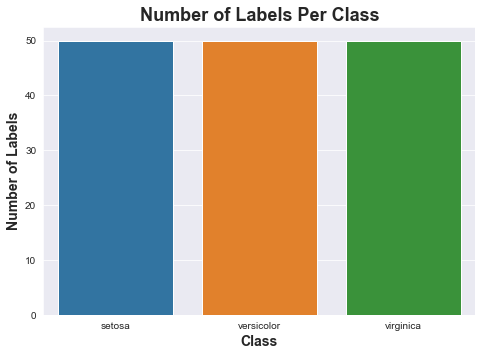

In [10]:
#PLOTTING THE NUMBER OF LABELS PER CLASS
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
sns.countplot(x=iris['target'])
axes.set_title('Number of Labels Per Class',fontsize = 18, fontweight = 'bold')
axes.set_xlabel('Class',fontsize = 14, fontweight = 'bold')
axes.set_ylabel('Number of Labels',fontsize = 14, fontweight = 'bold')
plt.show()

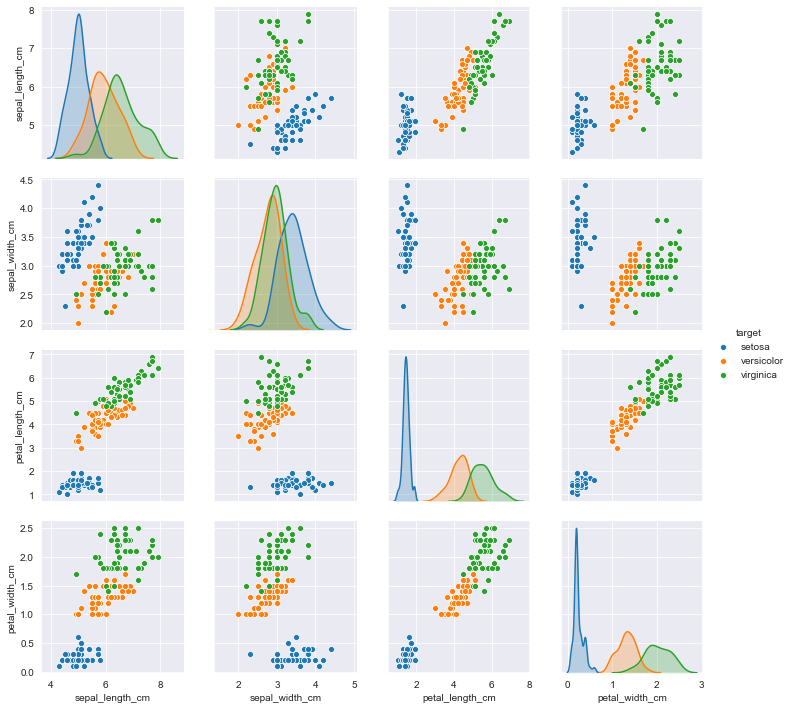

In [11]:
#PLOTTING 2D RELATIONSHIPS BETWEEN THE NUMERICAL FEATURES ON A SCATTER PLOT GRID USING SEABORN
sns.pairplot(iris,hue='target')
plt.show()

### Feature Engineering
Using the 4 feature columns, we will create some additional features of unique pairwise ratios between the columns.

In [12]:
#CREATE A COLUMN FOR EVERY UNIQUE PAIRWISE RATIO AMONG THE 4 EXISTING FEATURES
for items in list(combinations(iris.columns[:-1],2)):
    iris[items[0] + '/' + items[1]] = iris[items[0]]/iris[items[1]]

#SHOW FIRST 5 ROWS OF UPDATED IRIS DATASET
iris = iris[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm',
       'petal_width_cm', 'sepal_length_cm/sepal_width_cm',
       'sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm',
       'sepal_width_cm/petal_length_cm', 'sepal_width_cm/petal_width_cm',
       'petal_length_cm/petal_width_cm','target']]
iris.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,sepal_length_cm/sepal_width_cm,sepal_length_cm/petal_length_cm,sepal_length_cm/petal_width_cm,sepal_width_cm/petal_length_cm,sepal_width_cm/petal_width_cm,petal_length_cm/petal_width_cm,target
0,5.1,3.5,1.4,0.2,1.457143,3.642857,25.5,2.500000,17.5,7.0,setosa
1,4.9,3.0,1.4,0.2,1.633333,3.500000,24.5,2.142857,15.0,7.0,setosa
2,4.7,3.2,1.3,0.2,1.468750,3.615385,23.5,2.461538,16.0,6.5,setosa
3,4.6,3.1,1.5,0.2,1.483871,3.066667,23.0,2.066667,15.5,7.5,setosa
4,5.0,3.6,1.4,0.2,1.388889,3.571429,25.0,2.571429,18.0,7.0,setosa


### Feature Scaling
As stated earlier, because KNN is a distance-based algorithm feature scaling is especially important to prevent the impact of one feature masking input from other features. **Feature scaling addresses this problem by ensuring each feature column has the same mean and standard deviation**. A common way to execute this practice is to subtract each column by its column mean, before diving the difference by the column standard deviation (resulting in a column with an approximate mean of 0 and approximate standard deviation of 1). This is the method we will execute within this study.

Before feature scaling the data set, we will view descriptive statistics for each of the feature columns. This is important information to know in case new data is being streamed into live models for predictions, or if the presence of new labeled data results in the model being retrained with updated data.

In [13]:
iris.describe().iloc[[0,1,2,3,7]].transpose()

,count,mean,std,min,max
sepal_length_cm,150.0,5.843333,0.828066,4.300000,7.900000
sepal_width_cm,150.0,3.057333,0.435866,2.000000,4.400000
petal_length_cm,150.0,3.758000,1.765298,1.000000,6.900000
petal_width_cm,150.0,1.199333,0.762238,0.100000,2.500000
sepal_length_cm/sepal_width_cm,150.0,1.953681,0.400480,1.268293,2.961538
sepal_length_cm/petal_length_cm,150.0,2.018051,1.061621,1.050000,4.833333
sepal_length_cm/petal_width_cm,150.0,10.543959,10.972500,2.416667,52.000000
sepal_width_cm/petal_length_cm,150.0,1.188549,0.870099,0.376812,3.600000
sepal_width_cm/petal_width_cm,150.0,6.627701,7.951800,1.130435,41.000000
petal_length_cm/petal_width_cm,150.0,4.310500,2.489648,2.125000,15.000000


In [14]:
#FEATURE SCALING THE DATA
for cols in iris.columns[:-1]:
    iris[cols] = (iris[cols] - iris[cols].mean())/(iris[cols].std())

#SHOW FIRST 5 ROWS OF FEATURE SCALED IRIS DATA SET    
iris.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,sepal_length_cm/sepal_width_cm,sepal_length_cm/petal_length_cm,sepal_length_cm/petal_width_cm,sepal_width_cm/petal_length_cm,sepal_width_cm/petal_width_cm,petal_length_cm/petal_width_cm,target
0,-0.897674,1.015602,-1.335752,-1.311052,-1.239857,1.530495,1.363048,1.507244,1.367275,1.080273,setosa
1,-1.139200,-0.131539,-1.335752,-1.311052,-0.799909,1.395930,1.271911,1.096781,1.052881,1.080273,setosa
2,-1.380727,0.327318,-1.392399,-1.311052,-1.210874,1.504618,1.180774,1.463040,1.178639,0.879442,setosa
3,-1.501490,0.097889,-1.279104,-1.311052,-1.173116,0.987750,1.135205,1.009216,1.115760,1.281105,setosa
4,-1.018437,1.245030,-1.335752,-1.311052,-1.410287,1.463213,1.317479,1.589336,1.430154,1.080273,setosa


Following the feature scaling process, by again using the .describe() method we can see that the descriptive statistics of each feature has changed to reflect a mean of ~ 0 and a standard deviation of ~ 1.

In [15]:
iris.describe().iloc[[0,1,2,3,7]].transpose()

,count,mean,std,min,max
sepal_length_cm,150.0,-1.457168e-15,1.0,-1.863780,2.483699
sepal_width_cm,150.0,-1.638319e-15,1.0,-2.425820,3.080455
petal_length_cm,150.0,-1.292300e-15,1.0,-1.562342,1.779869
petal_width_cm,150.0,-5.543714e-16,1.0,-1.442245,1.706379
sepal_length_cm/sepal_width_cm,150.0,7.903863e-16,1.0,-1.711416,2.516623
sepal_length_cm/petal_length_cm,150.0,-8.511710e-17,1.0,-0.911860,2.651871
sepal_length_cm/petal_width_cm,150.0,-3.560115e-16,1.0,-0.740697,3.778177
sepal_width_cm/petal_length_cm,150.0,3.693342e-16,1.0,-0.932926,2.771468
sepal_width_cm/petal_width_cm,150.0,-1.428487e-16,1.0,-0.691324,4.322581
petal_length_cm/petal_width_cm,150.0,1.339669e-16,1.0,-0.877835,4.293579


### Model Development, Validation, and Selection
With the data properly inspected and scaled, we are ready to undergo the model development, validation, and selection process. This process will include a grid search methodology along with the custom KNN Classification and Repeated K-Fold Cross Validation frameworks above to find an optimal KNN Classification model. **This model will find the a subset of features, a K value, a distance metric, and a weighting schema which when used together maximizes prediction accuracy**.

First we will create a list which holds all possible feature subsets:

In [16]:
featuresubsets = []
for num in range(1,len(iris.columns[:-1])+1):
    #FOR SUBSETS OF SIZE 1, APPEND EACH FEATURE COLUMN NAME TO THE FEATURE SUBSETS LIST
    if num == 1:
        for cols in iris.columns[:-1]:
            featuresubsets.append(cols)
    #FOR SUBSETS OF SIZE > 1, APPEND ALL UNIQUE SUBSETS OF THAT SIZE TO THE FEATURE SUBSETS LIST
    else:
        for subsets in list(combinations(iris.columns[:-1],num)):
            featuresubsets.append(subsets)

len(featuresubsets)

1023

We have now created a list holding all 1023 possible unique subsets of the feature data. With these subsets identified, we can build our grid search. Our grid search will test each feature subset with a K Value between 1-20. In addition, for each feature subset/K Value combination 6 models will be generated where each model holds selects a different weighting schema/distance metric combination. For model validation, each model will be subjected to a Repeated K-Fold Cross Validation Process with 5 folds (80/20 split for each iteration) and 5 repeats. In summary, our grid search algorithm will build $1023*20*6 = 122760$ total models where each model is validated $5*5 = 25$ times to provide a generalized accuracy score depicting model performance:

In [ ]:
#LISTS TO STORE THE RESULTS OF THE GRID SEARCH
featureNames = []
numberOfFeatures = []
numberOfNeighbors = []
weightingSchema = []
distanceMetric = []
trainingAccuracy = []
testingAccuracy = []

#STORING THE FEATURE AND LABEL DATA IN SEPARATE STRUCTURES
X = iris.iloc[:,:-1]
Y = iris['target']

#GRID SEARCH ALGORITHM
#lOOP THROUGH ALL SUBSET POSSIBILITIES
for num in range(0,len(featuresubsets)):
    #CREATE XNEW, MODIFIED VERSION OF X THAT ONLY HOLDS THE FEATURE SUBSET
    if type(featuresubsets[num]) == str:
        XNew = X[[featuresubsets[num]]]
    else:
        XNew = X[list(featuresubsets[num])]
        
    #CREATE MODELS FOR K VALUES BETWEEN 1 AND 20 FOR EACH FEATURE SUBSET
    for K in range(1,21):
        #FOR EACH K VALUE/SUBSET COMBINATION, CREATE 6 TOTAL MODELS WITH EVERY WEIGHTING SCHEMA/DISTANCE METRIC COMBINATION
        for weight in ['standard','weighted']:
            for distance in ['euclidean','manhattan','chebyshev']:
                model = KNNClass(K,weighting = weight,distance_metric=distance)
                
                #STORE MODEL TRAIN/TEST ACCURACY SCORES FOR EACH ITERATION OF REPEATED K-FOLD CV MODEL VALIDATION PROCESS
                modeltrain = []
                modeltest = []
                
                #RUN EACH MODEL THROUGH A 5X5 REPEATED K-FOLD CV PROCESS, WHILE STORING ITS TRAIN/TEST ACCURACY SCORES FOR EVERY ITERATION
                rfk = Repkfoldcv(n_repeats = 5,n_splits = 5,shuffle=True)
                for train,test in rfk.split(XNew):
                    xtrain,xtest,ytrain,ytest = XNew.iloc[train],XNew.iloc[test],Y.iloc[train],Y.iloc[test]
                    model.fit(xtrain,ytrain)
                    modeltrain.append(model.score(xtrain,ytrain))
                    modeltest.append(model.score(xtest,ytest))
                    
                #STORE FEATURE NAMES OF MODEL
                featureNames.append(featuresubsets[num])
                #STORE NUMBER OF FEATURES OF MODEL
                numberOfFeatures.append(len(XNew.columns))
                #STORE K VALUE OF MODEL
                numberOfNeighbors.append(K)
                #STORE WEIGHTING SCHEMA OF MODEL
                weightingSchema.append(weight)
                #STORE DISTANCE METRIC OF MODEL
                distanceMetric.append(distance)
                #STORE AVERAGE TRAIN/TEST ACCURACY SCORES THROUGH MODEL VALIDATION PROCESS, PROVIDING GENERALIZED SCORE OF MODEL PERFORMANCE
                trainingAccuracy.append(mean(modeltrain))
                testingAccuracy.append(mean(modeltest))

In [21]:
#STORE GRID SEARCH RESULTS IN PANDAS DATAFRAME AND RETURN 10 BEST PERFORMING MODELS ACCORDING TO TESTING ACCURACY
SummaryReport = pd.DataFrame()
SummaryReport['Feature Names'] = featureNames
SummaryReport['Number of Features'] = numberOfFeatures
SummaryReport['Number of Neighbors'] = numberOfNeighbors
SummaryReport['Weighting Schema'] = weightingSchema
SummaryReport['Distance Metric'] = distanceMetric
SummaryReport['Training Accuracy'] = trainingAccuracy
SummaryReport['Testing Accuracy'] = testingAccuracy
SummaryReport.sort_values('Testing Accuracy', ascending=False,inplace=True)
SummaryReport = SummaryReport.head(10)
SummaryReport.set_index('Feature Names',inplace = True)
SummaryReport

,Number of Features,Number of Neighbors,Weighting Schema,Distance Metric,Training Accuracy,Testing Accuracy
Feature Names,,,,,,
"('sepal_length_cm/petal_length_cm', 'sepal_width_cm/petal_length_cm', 'sepal_width_cm/petal_width_cm')",3,3,standard,euclidean,0.981000,0.981333
"('sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm', 'sepal_width_cm/petal_length_cm')",3,6,weighted,chebyshev,0.986333,0.980000
"('sepal_length_cm/petal_length_cm', 'sepal_width_cm/petal_length_cm', 'sepal_width_cm/petal_width_cm')",3,3,standard,manhattan,0.984667,0.980000
"('sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm', 'sepal_width_cm/petal_length_cm')",3,6,weighted,euclidean,0.985333,0.978667
"('sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm', 'sepal_width_cm/petal_length_cm')",3,4,weighted,euclidean,0.985667,0.978667
"('sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm', 'sepal_width_cm/petal_length_cm')",3,5,weighted,chebyshev,0.985000,0.978667
"('sepal_length_cm/petal_length_cm', 'sepal_length_cm/petal_width_cm', 'sepal_width_cm/petal_length_cm')",3,4,weighted,chebyshev,0.985333,0.977333
"('petal_length_cm', 'sepal_length_cm/petal_length_cm', 'petal_length_cm/petal_width_cm')",3,17,standard,manhattan,0.979667,0.977333
"('sepal_length_cm/petal_length_cm', 'sepal_width_cm/petal_length_cm', 'petal_length_cm/petal_width_cm')",3,9,weighted,manhattan,0.978667,0.977333


Based off the summary report of the grid search results, a **3-NN model using 3 ratio features (sepal_length_cm/petal_length_cm, sepal_width_cm/petal_length_cm, sepal_width_cm/petal_width_cm) alongside a standard weighting schema and euclidean distance metric was the best performing model** across a Repeated K-Fold CV process with 5 repeats and 5 folds (25 model validation iterations). This best performing model also has near identical training/testing accuracies meaning that the model is neither overfitting or underfitting the data. Finally, with a relatively low number of features and low number of neighbors the model has certainly acheived model parsimony in being a fairly simple model with extremely high predictive power.

## Closing Remarks
The KNN Algorithm is one of the most widely used models for both classification and regression-based tasking. In closing, we wanted to provide some additional insight on the benefits and drawbacks of the model to help identify the best settings for deploying this model.

### Benefits of KNN
-     Intuitive distance-based methodology
-     Minimal prior assumptions of the data unlike other algorithms (linear/multiple regression)
-     Easy model training as the model simply stores the training data
-     Highly adaptable to new training data and multi-class frameworks
-     Very flexible/customizable framework (adapts to classification/regression, linear/non-linear problems, and can be used with a variety of distance metrics/weighting schemas)

### Drawbacks of KNN
-     Computationally expensive algorithm as distance needs to be computed between every test observation and every training observation before being sorted
-     Larger datasets can severely slow down the algorithm as a result of the above
-     Curse of Dimensionality: As the number of features increase, it becomes harder to find data points that are truly close together in higher dimensional space
-     Finding the optimal K-value can be difficult and time consuming
-     Imbalanced data and outliers can cause the model to be hypersensitive

Luckily, Python's scikit-learn library provides these models and algorithms premade and ready to implement through a single line of code. Scikit-learn provides source code for each of these options, and while we refrained from viewing outside references for the sake of building truly custom frameworks from scratch we highly recommend utilizing the full power of the scikit-learn library. Please view below for relevent packages that coincide with the content discussed throughout the article.

In [22]:
#DISTANCE METRICS
from sklearn.neighbors import DistanceMetric

#KNN CLASSIFICATION 
from sklearn.neighbors import KNeighborsClassifier

#KNN REGRESSION
from sklearn.neighbors import KNeighborsRegressor

#KNN REGRESSION ERROR METRICS
from sklearn.metrics import mean_squared_error,mean_absolute_error #RMSE IS SQUARE ROOT OF MEAN_SQUARED_ERROR

#TRADITIONAL TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

#REPEATED K-FOLD CROSS VALIDATION
from sklearn.model_selection import RepeatedKFold